# Linear model 
Tobias C. Haase \
Master's student of Psychology at [Goethe-University Frankfurt](https://www.goethe-university-frankfurt.de/en?locale=en)


Dataset: [Abrupt hippocampal remapping signals resolution of memory interference](https://openneuro.org/datasets/ds003707/versions/1.0.0)


Within the data exploration notebook, I outlined some information regarding the task design, the functional and structural data. This notebook will contain the development of the linear model as well as the results. 

Within the folder "preprocessing attempts" various attempts to preprocess the data are outlined. Preprocessing on my own device failed, thankfully I was able to preprocess most participants via [brainlife](https://brainlife.io/).

These are the preprocessing and quality control pipelines used:

Quality controle was performed using the [Magnetic Resoncance Imaging Quality Controle pipeline](https://mriqc.readthedocs.io/en/latest/) (22.0.6). 

The preprocessing was performed using [fMRI-Prep](https://fmriprep.org/en/stable/) (20.2.3)



Fistly I will load a preprocessed image. Then, going from the previously explored event files, I will briefly mention the experimental paradigm again. These will then be used for a generalized linear model (GLM).

I will first do the linear model for subject 6 to see if everything works (this subject was used as an example as it was the first participant with data for all runs).  

In [2]:
#Import of things I need later:
import os
import numpy as np
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain;

/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [3]:
#File paths
fmri_img_run1_sub6_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/sub-06_task-scene_run-01_desc-preproc_bold.nii.gz'
anat__img_run1_sub6_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/sub-06_task-scene_run-01_desc-preproc_T1w.nii.gz'

I have now the file paths to the mri images. Now I still need the event files to define respective contrasts. 


In [4]:
events_run1_sub6_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/ds003707/sub-06/func/sub-06_task-scene_run-01_events.tsv'

import pandas as pd
events_run1_sub6 = pd.read_table(events_run1_sub6_path)

events_run1_sub6

,onset,duration,correct,trial_type,response_time
0,10,4,0.0,1_A9,NaN
1,14,4,1.0,1_A2,1.486898
2,18,4,1.0,1_A1,0.752162
3,22,4,1.0,1_B4,0.334689
4,26,4,1.0,1_B0,0.368064
...,...,...,...,...,...
73,324,4,0.0,2_B16,NaN
74,328,4,1.0,foil05,0.735685
75,332,4,1.0,2_A17,0.534958
76,336,4,1.0,foil03,0.785550


In [5]:
events_run1_sub6 = events_run1_sub6[["onset", "duration", "trial_type"]]
for i, row in events_run1_sub6.iterrows():
    events_run1_sub6["trial_type"][i] = events_run1_sub6["trial_type"][i].replace('1_', 'Learned_')
    events_run1_sub6["trial_type"][i] = events_run1_sub6["trial_type"][i].replace('2_', 'Learned_')


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Each trial has a certain onset, the same duration and then the response is either correct or not correct. 
We also see that there is a certain response time - if this is failed the trial is listed to be `0.0` i.e. not correct. 


Now, lets generate a design matrix with these event files. Recall that a 'design matrix' is a matrix that contains the explanatory variables. Here, the explanatory variables also involes the regressors that are the result of the previously mentioned pipelines!

First, before I can generate a `FirstLevelModel`, I need to extract the repetion time.

In [6]:
from nilearn.glm.first_level import FirstLevelModel

#Now I need the TR and other parameters. I previously extracted them using the 'pybids module! Here I will take also show a different attempt:

import nibabel as nib ;

fmri_img_run1_sub6 = nib.load(fmri_img_run1_sub6_path);
#The get_zooms function contains voxel size with the 4th entry being the time, this is therefore the repetiton time!
fmri_img_run1_sub6.header.get_zooms()[3]

2.0

Knowing the repition time, we can set up the `FirstLevelModel`.

Briefly explained, I understand a first level model as a first step used to generate the linear models later - there are certain things like the haemondynamic response that needs to be modelled, which will be done in this first step!

Here is an explanation on the parameters:
- `T_r` refers to the repetion time, this was extracted above. 
- `Drift mode`: It's a `cosine functio` that aims to remove effects of heart rate etc. The standard setting here is 1/128 Hz. In the design matrix this will end up as a column with almost no change in color, only very slight drift!
- The `hrf-model` part specifies the`hemodynamic response model`: The event file has certain events, but this needs to be converted into a ["reference BOLD signal for the design matrix"](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html). Here the basic wasn't choosen, but the `spm`. This stands for statistical parametric map. In contrast to the basic the undershoot following the haemondynamic response is said to be weaker here.
- Fruthermore, a `high pass filte` can be applied. The high pass filter will let [higher frequencies pass](https://www.brainvoyager.com/bv/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html), the cut-off here is set to another value than the standard! What does this mean? I will have an additional confound with the lower frequencies, them being included in the model instead of them being removed!
&nbsp;


- `noise_model`: There are different options for noise models. The `ar1` is the preset noise model. A ordinary least squared approach, autoregressive approaches of higher order or other models could have been used. 
&nbsp;


- I don't want the signal to be scaled, so this is set to false!

In [7]:
fmri_glm_run1_sub6 = FirstLevelModel(t_r=2.0,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./128,
                           signal_scaling=False,
                           minimize_memory =  False)

This model still lacks the confounds.

In [8]:
import pandas as pd
import numpy as np
confounds_run1_sub6 = pd.read_csv('/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/sub-06_task-scene_run-01_desc-confounds.tsv', 
                                  delimiter = '\t')
#The delimiter needs to be set to \t as it uses tab to differentiate different entries. 

column_names = list(confounds_run1_sub6.columns.values)
column_names

['global_signal',
 'global_signal_derivative1',
 'global_signal_power2',
 'global_signal_derivative1_power2',
 'csf',
 'csf_derivative1',
 'csf_derivative1_power2',
 'csf_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_power2',
 'white_matter_derivative1_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 'rmsd',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 't_comp_cor_05',
 't_comp_cor_06',
 't_comp_cor_07',
 't_comp_cor_08',
 't_comp_cor_09',
 't_comp_cor_10',
 't_comp_cor_11',
 't_comp_cor_12',
 't_comp_cor_13',
 'a_comp_cor_00',
 'a_comp_cor_01',
 'a_comp_cor_02',
 'a_comp_cor_03',
 'a_comp_cor_04',
 'a_comp_cor_05',
 'a_comp_cor_06',
 'a_comp_cor_07',
 'a_comp_cor_08',
 'a_comp_cor_09',
 'a_comp_cor_10',
 'a_comp_cor_11',
 'a_comp_cor_12',
 'a_comp_cor_13',
 'a_comp_cor_14',
 'a_comp_cor_15',
 'a_comp_cor_16',
 'a_comp_cor_17',
 'a_comp_cor_18',
 'a_comp_cor_19',
 'a_comp_cor_20',


Only a portion of the entries are needed here. 

The following are extracted, following the recommedation from the [fmriprep-doc](https://fmriprep.org/en/stable/outputs.html#confounds). 
- The parameters of head motion, i.e. the transverse and rotational movements. `trans_x`, `trans_y`, `trans_z`, `rot_x`, `rot_y`, `rot_z`.

&nbsp;
The following three are copy-pastad from said website:
- `csf - the average signal within anatomically-derived eroded CSF mask`
- `white_matter - the average signal within the anatomically-derived eroded WM masks`
-  `global_signal - the average signal within the brain mask`

- the rmsd - this also takes head motion into account but using a different statistical approach.
- framewise_displacement - another classic measure of movement. 

As a high-pass filter is included, I will not include regressors for signal drift. 

In [9]:
confounds_glm_run1_sub6 = confounds_run1_sub6[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
confounds_glm_run1_sub6

,white_matter,global_signal,framewise_displacement,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,rmsd
0,5975.756217,6126.668641,0.000000,10444.063602,0.034271,-0.011028,0.033954,-9.374490e-05,-0.000297,0.000453,0.000000
1,5978.942933,6126.743570,0.025447,10346.109765,0.027841,-0.012104,0.039323,-1.323490e-23,-0.000346,0.000343,0.011883
2,5980.483029,6132.032324,0.033753,10362.884937,0.033482,-0.003517,0.024437,0.000000e+00,-0.000337,0.000259,0.018279
3,5978.650057,6129.665218,0.036861,10217.434957,0.028032,0.007799,0.031598,-1.201740e-04,-0.000375,0.000158,0.017710
4,5976.735798,6126.883741,0.042074,10232.444192,0.025611,-0.012633,0.035864,-2.646980e-23,-0.000372,0.000334,0.023282
...,...,...,...,...,...,...,...,...,...,...,...
172,5967.351326,6132.775404,0.052491,10434.865707,-0.027287,0.028218,-0.022084,-1.446660e-04,-0.001686,-0.000312,0.027091
173,5968.436398,6133.940994,0.070713,10374.021769,-0.025793,0.058979,-0.031075,-5.428840e-04,-0.001758,-0.000193,0.038925
174,5971.929799,6125.377610,0.017491,10288.476298,-0.022662,0.057221,-0.036650,-5.242960e-04,-0.001830,-0.000142,0.008184
175,5971.281566,6122.549079,0.064655,10343.196182,-0.020640,0.030443,-0.018628,-3.507080e-04,-0.001647,-0.000142,0.034101


I have now specified the confounds I will need. Before I can run the model, I need to create a sample mask to remove the first 10 seconds!

In [15]:
import nilearn.image as nli

#Loading the image to get the amount of volumes.
sub06_run1_bold = nli.load_img('/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/sub-06_task-scene_run-01_desc-preproc_bold.nii.gz')
sample_masks = np.arange((sub06_run1_bold.get_fdata().shape[3]))[5:]  
#creating an array with the amount entries equaling volumes except the first 10 seconds / 5 volumes. 
sample_masks

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176])

Now lets run the model!

In [ ]:
fmri_glm_run1_sub6 = fmri_glm_run1_sub6.fit(fmri_img_run1_sub6_path, events = events_run1_sub6, \
                                          sample_masks = sample_masks, \
                                          confounds = confounds_glm_run1_sub6)

In [ ]:
design_matrix = fmri_glm_run1_sub6.design_matrices_[0]

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

There was 36 objects or scenes. Each was repeated twice per run. There were 18 object scene pairmates as explained in the data exploration. 

Let's save this design matrix!

In [40]:
outdir = 'results'
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/design_matrizes/")
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

To ensure this works, I want to inspect the expected response for a random item. 

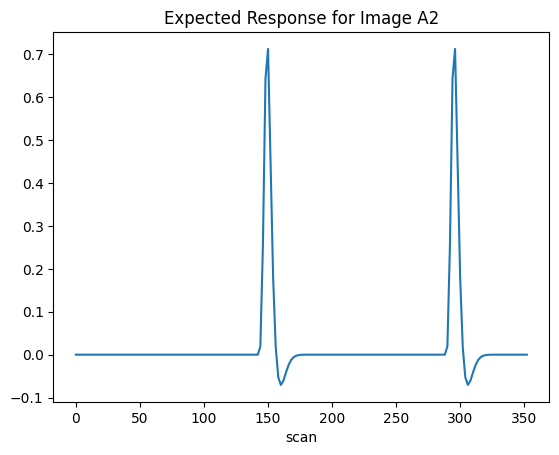

In [54]:
plt.plot(design_matrix['A2']) 
plt.xlabel('scan')
plt.title('Expected Response for Image A2')
plt.show()

Thus far everything seems to work as intended. 

Now I want to identify voxels that have significant effects within the next section.

### Detection of Significant Voxels

Firstly, I will need to get the betas for every voxel. To achieve this, I need to first get the contrasts. These will require some data wrangling, which will be done in the following. 

In [157]:
from numpy import array
array_learned = np.array([0]*design_matrix.shape[0])
                            
conditions = {
    'active - Learned': np.array([0]*design_matrix.shape[1]),
    'active - Foil':   np.array([0]*design_matrix.shape[1]),
}

In [160]:
i = 0
for col in design_matrix:
    if "foil" in col:     #Creating the contrast for the lure images. 
        conditions['active - Foil'][i] = 1
    elif "Learned_A" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    elif "Learned_B" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    i = i+1   

Let's have a look at the conditions and see if it worked.

In [161]:
conditions

{'active - Learned': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'active - Foil': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Above, I have created some first contrasts to test the rest of the glm. If this works, I may change it according to what I wanted to do initially!

Here is the contrast for the learned images:

<AxesSubplot:label='conditions'>

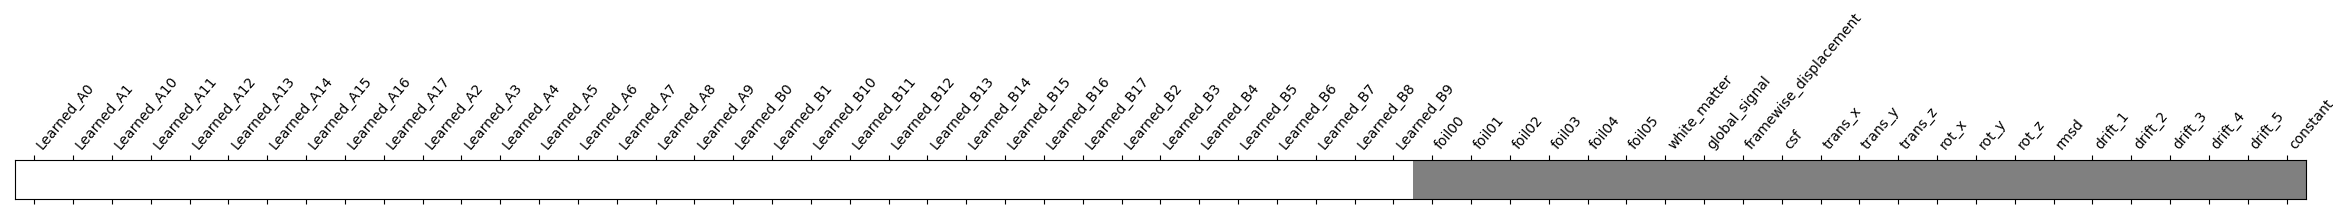

In [173]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Learned'], design_matrix=design_matrix)

Here is the contrast for the lures. 

<AxesSubplot:label='conditions'>

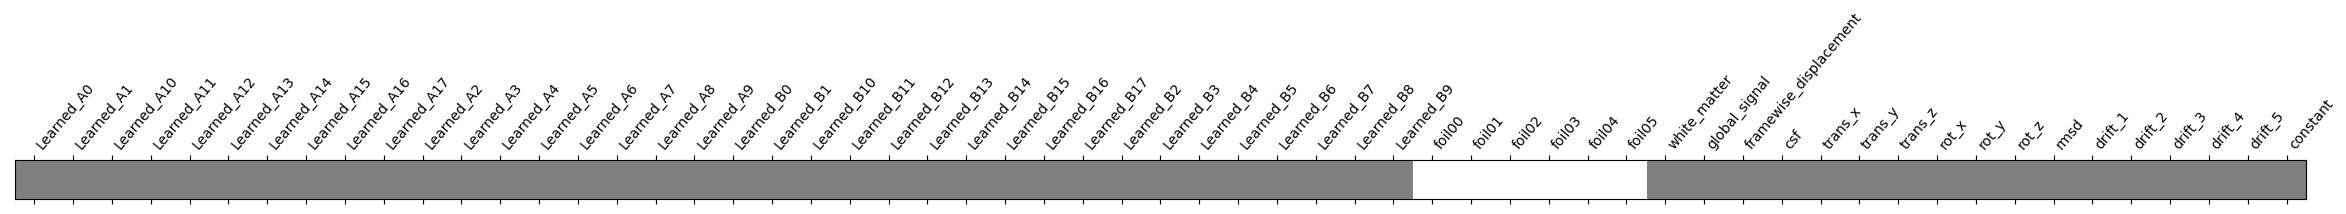

In [174]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Foil'], design_matrix=design_matrix)

In [165]:
eff_map = fmri_glm_run1_sub6.compute_contrast(conditions['active - Learned'],
                                    output_type='effect_size')
eff_map

- To be added

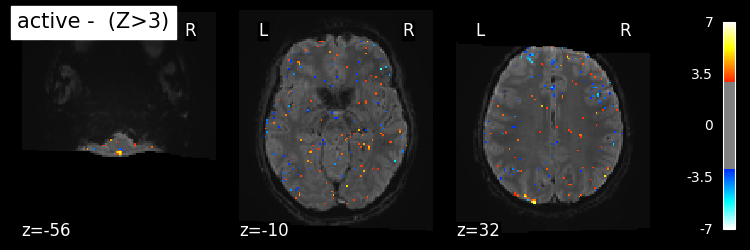

In [172]:
z_map_sub6_run1 = fmri_glm_run1_sub6.compute_contrast(conditions['active - Learned'],
                                  output_type='z_score')

#Get the mean image
from nilearn.image import mean_img
mean_img_run1_sub6 = mean_img(fmri_img_run1_sub6_path)


plot_stat_map(z_map_sub6_run1, bg_img=mean_img_run1_sub6, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active -  (Z>3)')
plt.show()

I need to add more above. 

## Extending the GLM to the Other Runs

Before I can incorporate the other runs, I need to decide on how to crossvalidate. 
The stimuli are the same across runs and across people. There are two options:
1. Use a certain number of runs and cross-validate by using runs from every participants. 
2. Use a certain amount of participants to cross-validate. 

As at the moment of making this decision, it is uncertain how many people will actually be fully preprocessed, I am deciding to cross-validate by using a few runs per person. It seems like a 4 to 2 split would be justified. 

First I am loading all fmri-images and I am concatenating them. This first step will generate the files in one object.

In [14]:
import os 
fmri_img_sub_6 = []
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/")
for i in os.listdir():
    file_name = i
    if file_name.endswith("bold.nii.gz") and "scene" in file_name: 
         fmri_img_sub_6.append(file_name)
    else:
         continue

Now, I have all the image paths. But the actual images still need to be attached to each other!

In [15]:
fmri_img_sub_6

['sub-06_task-scene_run-07_desc-preproc_bold.nii.gz',
 'sub-06_task-scene_run-05_desc-preproc_bold.nii.gz',
 'sub-06_task-scene_run-04_desc-preproc_bold.nii.gz',
 'sub-06_task-scene_run-03_desc-preproc_bold.nii.gz',
 'sub-06_task-scene_run-06_desc-preproc_bold.nii.gz',
 'sub-06_task-scene_run-01_desc-preproc_bold.nii.gz']

This needs to be continued, but I need to properly set everything up for one run before I can continue here.

![tobecontinued](https://media.giphy.com/media/W9wHF6yVazlrW/giphy.gif)